# Simulation of non-equilibrium dynamics with neural quantum states
> **Markus Schmitt**
>
> *Regensburg University / Forschungszentrum Jülich*
>
> [www.computational-quantum.science](https://www.computational-quantum.science)
>

## Importing some libraries

Let's start by importing some libraries, that we will need later.

We will use our [jVMC](https://www.github.com/markusschmitt/vmc_jax) library as a basis to work with neural quantum states. It implements all basic operations needed to work with neural quantum states.

In [1]:
# Our jVMC library implements all required basic operations needed to work with NQS
import jVMC

import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random

from functools import partial

from IPython import display
from IPython.display import clear_output
import time

# Some useful functions are defined in `src/helper_functions.py`. Check them out, we'll use them later in this notebook.
from src.helper_functions import *

## Define a neural network

We define a single-layer feed-forward neural network with the following architecture:

<img src="figures/notebook_ffn.png" width=400 />


The network has real weights and *two real-valued outputs*, which will be interpreted as the *real and imaginary parts* of the logarithmic wave function amplitude $\log\psi_\theta(s)$.



ANN visualization generated [here](http://alexlenail.me/NN-SVG/index.html).

We use the [Flax library](https://www.github.com/google/flax) to define NQS architectures.

In [2]:
import flax.linen as nn # import the flax.linen module

class MyNet(nn.Module):
    width: int = 20
        
    def setup(self):
        
        # First dense layer
        self.L1 = nn.Dense(self.width, 
                         use_bias=True,
                         dtype=jVMC.global_defs.tReal
                        )
        
        # Second dense layer
        self.L2 = nn.Dense(2, 
                 use_bias=True,
                 dtype=jVMC.global_defs.tReal
                )
        
    def __call__(self, s):
        # This function defines how the ANN is evaluated
        
        z = self.L1(s) # Apply first dense layer to get pre-activations z
        a = nn.elu( z ) # Apply activation function to get activations a
        
        output = self.L2(a) # Apply the second dense layer
        
        return output[0] + 1.j*output[1] # The two outputs correspond to real and imaginary parts

## Initialize a neural quantum state

Initialize an instance of the `NQS` class (-> [Documentation](https://jvmc.readthedocs.io/en/latest/vqs.html#jVMC.vqs.NQS)) from the jVMC library using our custom ANN architecture from above with a given `width`.

In [3]:
from jVMC.vqs import NQS
from jVMC.nets.activation_functions import poly5, poly6

width = 60
psi = NQS(MyNet(width=width))

Next, we create a generic computational basis state (a random bit-string) to test the evaluation of the NQS.

**Important**: In jVMC, data arrays typically have two leading dimensions:
- the leading *device dimension* to distribute data across multiple locally available GPUs.
- the second *batch dimension* for vectorization on a single GPU.

In [4]:
L = 8 # Fix the system size

# Get a random configuration; Notice the shape with two leading dimensions
s = 1*jax.random.bernoulli(jax.random.PRNGKey(1234), shape=(1,1,L))

print(s)

[[[1 1 0 1 1 1 0 1]]]


We will use a logarithmic encoding of the wave function coefficients, i.e.
$$\log\psi_\theta(\mathbf s)\equiv \text{ANN}_\theta(\mathbf s)$$
Let's evaluate our NQS on the example configuration!

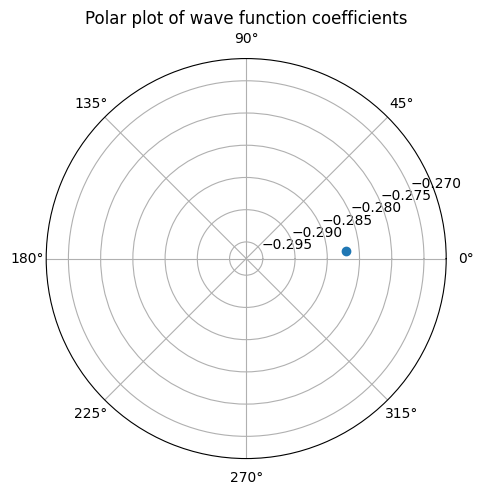

In [5]:
coeff = psi(s) # Evaluate the NQS

plot_coeffs(coeff) # Plot the result in a polar plot

Let's check how many parameters we have in our NQS ansatz:

In [6]:
params = psi.get_parameters() # Get vector of network parameters

print(params.shape)

(662,)


### Batched evaluation

The NQS class supports batched network evaluations on multiple input configurations, which is crutial for performance.

In [7]:
# Get a batch of random configurations
s_batch = 1*jax.random.bernoulli(jax.random.PRNGKey(1234), shape=(1,13,L))

print(s_batch)

[[[0 1 0 1 0 1 0 1]
  [0 0 1 0 1 1 0 1]
  [1 1 0 1 1 0 1 1]
  [1 1 1 0 1 1 0 0]
  [0 1 1 1 0 1 0 0]
  [1 0 1 1 0 0 1 0]
  [1 1 0 1 1 1 1 0]
  [0 0 1 1 1 0 0 1]
  [1 1 1 0 1 0 0 0]
  [1 0 0 0 1 1 0 1]
  [1 0 0 0 0 1 0 0]
  [1 0 1 1 0 1 0 0]
  [1 1 0 0 0 1 0 1]]]


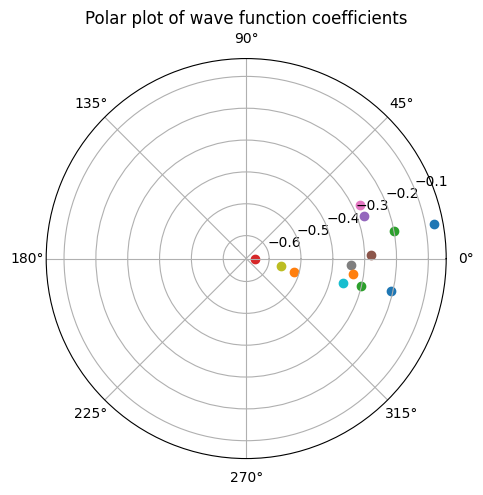

In [8]:
coeffs = psi(s_batch) # Evaluate the NQS

plot_coeffs(coeffs)

## Operators: Set up observables

The `BranchFreeOperator` class (-> [Documentation](https://jvmc.readthedocs.io/en/latest/operator.html#branch-free-operator-class)) can be used to create physical operators.

In [9]:
# Import some stuff from the operator module
from jVMC.operator import BranchFreeOperator
from jVMC.operator import Sz, Sx
from jVMC.operator import scal_opstr

Let's create an operator that measures the polarization in the $x$-direction normalized by system size:

$$\hat X=\frac{1}{L}\sum_{l=1}^L\hat\sigma_l^x$$

In [10]:
X = BranchFreeOperator() # Initialize an instance of the BranchFreeOperator class

# Individual terms of a sum can be added sequentially
for l in range(L):
    X.add( scal_opstr(1. / L, (Sx(l), )) )

The `BranchFreeOperator` class implements the computation of non-zero matrix elements of the operator for a given input configuration:

In [11]:
# Create input configuration (all spins down)
s1 = jax.numpy.zeros((1,1,L), dtype=np.int32)

# Compute non-zero matrix elements
s_primes, matrix_elements = X.get_s_primes(s1)

print("Input configuration:", s1)
print()
print("s_primes:\n", s_primes)
print()
print("matrix_elements:\n", matrix_elements)

Input configuration: [[[0 0 0 0 0 0 0 0]]]

s_primes:
 [[[1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 1]]]

matrix_elements:
 [[[0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j
   0.125+0.j]]]


## Measuring expectation values: sampling

The `MCSampler` class (-> [Documentation](https://jvmc.readthedocs.io/en/latest/sampler.html#jVMC.sampler.MCSampler)) implements Monte Carlo sampling from the given NQS.

In [12]:
from jVMC.sampler import MCSampler

mc_sampler = MCSampler(psi, (L,), 1234, updateProposer=jVMC.sampler.propose_spin_flip)

Generate `numSamples` samples.

In [13]:
configs, coeffs, _ = mc_sampler.sample(numSamples=10)

print("Sampled configurations:\n", configs)
print()
print("Corresponding (log.) wave function coefficients:\n", coeffs)

Sampled configurations:
 [[[1 0 0 0 0 0 1 0]
  [1 1 0 1 0 1 1 1]
  [0 1 0 0 0 1 0 1]
  [0 1 0 0 0 0 0 0]
  [0 0 1 0 1 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 1 0 1 0 0 0 1]
  [1 0 0 1 1 0 0 1]
  [0 0 0 0 0 1 1 0]
  [0 1 0 0 0 1 0 0]]]

Corresponding (log.) wave function coefficients:
 [[-0.39100103+0.05894903j -0.51021864+0.36975864j -0.38815933-0.05309092j
  -0.16680387+0.13394657j -0.92519258-0.08364353j -0.10409231+0.25651043j
  -0.00791821+0.13435393j -0.47784587-0.10674208j -0.3201463 +0.40799075j
  -0.31762467+0.25800204j]]


Using the `MCSampler` we can now estimate the quantum expectation value

$$\langle\psi_\theta|\hat X|\psi_\theta\rangle=\sum_s\frac{|\psi_\theta(s)|^2}{\langle\psi_\theta|\psi_\theta\rangle}\underbrace{\sum_{s'}X_{s,s'}\frac{\psi_\theta(s')}{\psi_\theta(s)}}_{\equiv O_{\text{loc}}(\mathbf s)}
\equiv\langle\langle O_{\text{loc}}(\mathbf s)\rangle\rangle_{|\psi(\mathbf s)|^2}
$$

The operator class provides a member function to compute the **local estimator** $O_{\text{loc}}(\mathbf s)$ for a given set of configurations. In order to  compute statistics from the sample, we can use the `SampledObs` class (-> [Documentation](https://jvmc.readthedocs.io/en/latest/stats.html)):

In [14]:
from jVMC.stats import SampledObs

configs, coeffs, ps = mc_sampler.sample(numSamples=500)
Oloc = X.get_O_loc(configs, psi, coeffs)

print("`Oloc` is a vector of shape ", Oloc.shape)

Oloc = SampledObs(Oloc, ps)
OlocMean = Oloc.mean()[0]

print("The sample mean is O_loc =", OlocMean)

`Oloc` is a vector of shape  (1, 500)
The sample mean is O_loc = (0.9536851178301284+0.0028863449496632637j)


For convenience, measuring observable expectation values is implemented in the utility function `measure` (-> [Documentation](https://jvmc.readthedocs.io/en/latest/util.html#jVMC.util.util.measure)).

In [15]:
from jVMC.util import measure

observables = {
    "X": X
}

# measure expectation value of observables contained in the dictionary from above
# using the given NQS and sampler.
obs = measure(observables, psi, mc_sampler)

print("Expectation value of X: %.3f+/-%.3f" % (obs["X"]["mean"][0], obs["X"]["MC_error"][0]))
print("Variance of X: %.3f" % (obs["X"]["variance"][0]))

Expectation value of X: 0.952+/-0.010
Variance of X: 0.011


## Computing gradients

The `NQS` class provides a member function to compute the gradient of the (logarithmic) wave function,

$$\Gamma_k(s)=\frac{\partial}{\partial\theta_k}\log\psi_\theta(s)$$

**Notice:** We use logarithmic encoding ($\log\psi_\theta(\mathbf s)\equiv \text{ANN}_\theta(\mathbf s)$). Therefore,

$$\Gamma_k(s)=\frac{\partial}{\partial\theta_k}\text{ANN}_\theta(s)$$

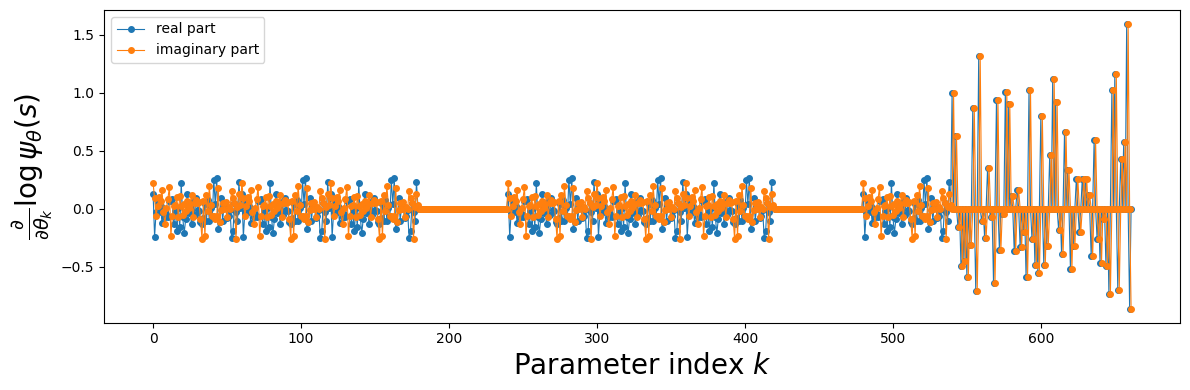

In [16]:
grads = psi.gradients(s) # Compute (logarithmic) derivatives

plot_gradient(grads)

## Ground state search

### Create a Hamiltonian

In the following we will be interested in the one-dimensional quantum Ising model:

$$\hat H=-\sum_{l=1}^L\hat\sigma_l^x\hat\sigma_{l+1}^x - g\sum_{l=1}^L\hat\sigma_l^z  - h\sum_{l=1}^L\hat\sigma_l^x $$

In [17]:
g = 0.3
h = 0.25

H = BranchFreeOperator()

for l in range(L):
    H.add( scal_opstr(-1.0, (Sx(l), Sx((l+1)%L))) )    # - Sx(l) Sx(l+1)
    H.add( scal_opstr(-h, (Sx(l),)) )                  # -h Sx(l)
    H.add( scal_opstr(-g, (Sz(l),)) )                  # -g Sz(l)

In [18]:
observables["energy"] = H

### Gradient descent to find the ground state

The initial state for a time evolution can typically be defined as the ground state of a suited Hamiltonian $\hat H$.

$\Rightarrow$ We would like to optimize the parameters of our NQS, such that it approximates the minimal energy eigenstate of $\hat H$.

The workhorse for this purpose is gradient-based optimization.

The gradient of the energy expectation value with respect to the NQS parameters is

$$\frac{\partial}{\partial\theta_k} \frac{\langle\psi_\theta|\hat H|\psi_\theta\rangle}{\langle\psi_\theta|\psi_\theta\rangle}
=2\text{Re}\bigg[
    \frac{\langle\partial_k\psi_\theta|\hat H|\psi_\theta\rangle}{\langle\psi_\theta|\psi_\theta\rangle}
    -\frac{\langle\partial_k\psi_\theta|\psi_\theta\rangle}{\langle\psi_\theta|\psi_\theta\rangle}\frac{\langle\psi_\theta|\hat H|\psi_\theta\rangle}{\langle\psi_\theta|\psi_\theta\rangle}
\bigg]
\equiv
2\text{Re}\Big[\langle\langle \Gamma_k(\mathbf s)^*E_{\text{loc}}(\mathbf s)\rangle\rangle_{|\psi(\mathbf s)|^2}^C\Big]
$$

In [19]:
def run_gs_search(numSteps, learningRate, numSamples, H, L, psi, displayPlot=True):

    mc_sampler = MCSampler(psi, (L,), 1234, updateProposer=jVMC.sampler.propose_spin_flip)
    
    energies = np.zeros((numSteps, 3))

    if displayPlot:
        plt.ion()
        plt.xlim(0, numSteps)
        plt.xlabel("Optimization step")
        plt.ylabel("Energy")

    for n in range(numSteps):
        configs, coeffs, ps = mc_sampler.sample(numSamples=numSamples)  # sample

        grads = SampledObs(psi.gradients(configs), ps)           # get log-derivatives
        Eloc = SampledObs(H.get_O_loc(configs, psi, coeffs), ps) # get local energies

        Egrad = grads.covar(Eloc) # Compute energy gradient according to formula above

        # Parameter update
        newParams = psi.get_parameters() - 2.0*jnp.real(learningRate * Egrad).ravel()
        psi.set_parameters(newParams)

        energies[n, 0] = n
        energies[n, 1] = np.real(Eloc.mean()[0])
        energies[n, 2] = np.real(Eloc.var()[0])

        if displayPlot:
            # Plot data
            npdata = np.array(energies)
            plt.plot(npdata[0:n, 0], npdata[0:n, 1], c="red")
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            print(n, obs["energy"]["mean"][0])

    if displayPlot:
        display.clear_output(wait=True)
    
    return energies


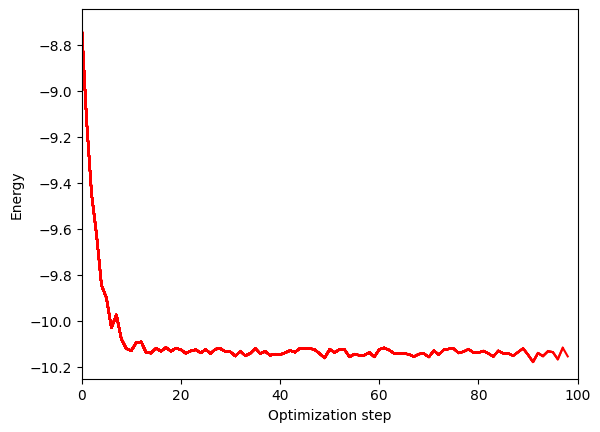

In [20]:
numSteps = 100
learningRate = 0.025
numSamples = 500

psi = NQS(MyNet(width=50))

energies = run_gs_search(numSteps, learningRate, numSamples, H, L, psi)

Text(0, 0.5, 'Energy variance')

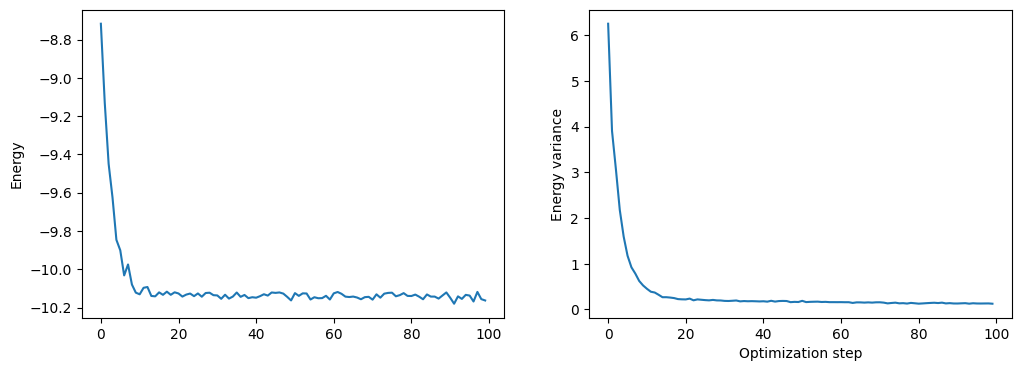

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(energies[:,0], energies[:,1])
ax[1].set_xlabel("Optimization step")
ax[0].set_ylabel("Energy")
ax[1].plot(energies[:,0], energies[:,2])
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("Energy variance")

<img src="figures/confinement.png" width=1000 />

Link to reference: [Kormos et al., Nat. Phys (2017)](https://www.nature.com/articles/nphys3934)

## Initial ground state search

We want to initialize the system in the state

$$|\psi_0\rangle=\bigotimes_l|\rightarrow\rangle_l$$

This is achieved by a ground state search with the Hamiltonian $\hat H_{GS}=-\sum_l\hat\sigma_l^x$.

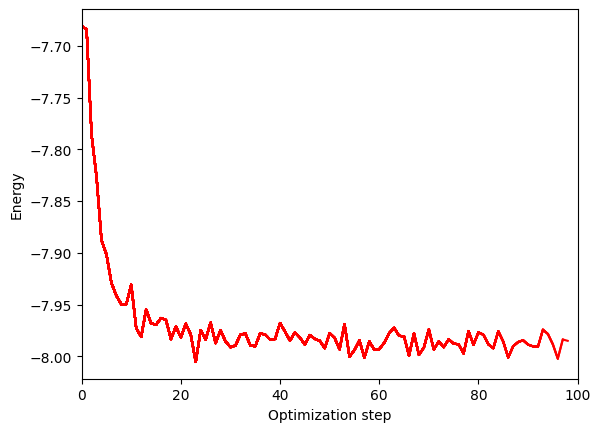

In [38]:
L=8
width=30

psi = NQS(MyNet(width=width), batchSize=2**L)

H_gs = BranchFreeOperator()
for l in range(L):
    H_gs.add( scal_opstr(-1.0, (Sx(l),)) )
    
run_gs_search(100, learningRate, numSamples, H_gs, L, psi);

## Set up the time-dependent variational principle (TDVP)

The `TDVP` class (-> [documentation](https://jvmc.readthedocs.io/en/latest/util/tdvp.html#jVMC.util.tdvp.TDVP)) from the utilities implements the TDVP time step. It will be used to determine the parameter update $\dot\theta$ using the TDVP equation  $$S_{k,k'}\dot\theta_{k'}=-iF_k$$.

In [40]:
from jVMC.util import TDVP

# Use exact sampler for demonstration purposes
from jVMC.sampler import ExactSampler
sampler = ExactSampler(psi, L)

tdvpEquation = TDVP(sampler, 
                    pinvTol=1e-8,
                    rhsPrefactor=1.j,
                    makeReal='imag'
                   )

## Set up the time evolution

Now, we can write a function, that performs the time propagation of the NQS:

In [24]:
def run_time_evolution(psi, H, tdvpEquation, tmax, observables):
    t = 0.0    # Initial time

    # Initialize an adaptive ODE integrator
    stepper = jVMC.util.stepper.AdaptiveHeun(timeStep=1e-3, tol=1e-4)

    observables["energy"] = H
    data = {"parameters": [], "observables": [], "residuals": []}
    
    # Measure observables
    obs = measure(observables, psi, sampler)
    data["observables"].append([t, obs["energy"]["mean"][0], obs["X"]["mean"][0]])
    data["parameters"].append(psi.params.unfreeze())

    while t < tmax:
        tic = time.perf_counter()

        # TDVP step
        dp, dt = stepper.step(t,                      # current time
                              tdvpEquation,           # TDVP object
                              psi.get_parameters(),   # current network parameters
                              hamiltonian=H,          # Hamiltonian operator
                              psi=psi,                # NQS object
                              normFunction=partial(norm_fun, df=tdvpEquation.S_dot)
                                                      # Norm for adaptive time step
                             )
        psi.set_parameters(dp)
        t += dt

        # Get TDVP error and residual of solving TDVP equation
        tdvpErr, linEqRes = tdvpEquation.get_residuals()

        # Measure observables
        obs = measure(observables, psi, sampler)
        data["observables"].append([t, obs["energy"]["mean"][0], obs["X"]["mean"][0]])
        data["parameters"].append(psi.params.unfreeze())
        data["residuals"].append([t-dt, tdvpErr, linEqRes])

        # Write some meta info to screen
        write_info(t, dt, tdvpErr, linEqRes, obs, tic)
        
    return data

# Run the simulation

In [41]:
g = 0.5
h = 0.2

H = BranchFreeOperator()

for l in range(L):
    H.add( scal_opstr(-1.0, (Sx(l), Sx((l+1)%L))) )    # - Sx(l) Sx(l+1)
    H.add( scal_opstr(-h, (Sx(l),)) )                  # -h Sx(l)
    H.add( scal_opstr(-g, (Sz(l),)) )                  # -g Sz(l)

data = run_time_evolution(psi, H, tdvpEquation, , observables)

save_to_disk(data, L, g, h, fn="ffn_width="+str(width)+"_")

>> t = 3.019256

   Time step size: dt = 2.14e-02
   Residuals :               TDVP error = 1.77e-12
               Linear equation residual = 3.97e-09
      Energy : -9.595458 +/- 0.000000
== Total time for this step: 3.842160s



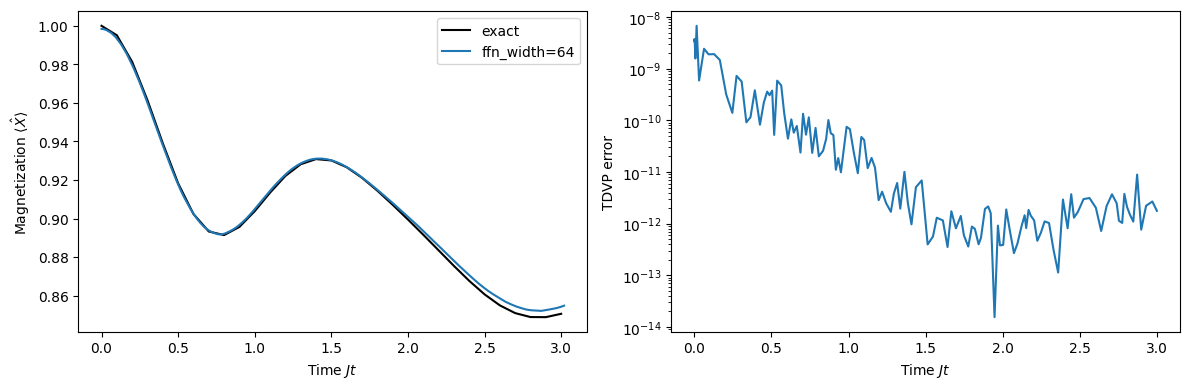

In [42]:
plot_observables(L, g, h, fns=["ffn_width="+str(width)+"_"])

## Possible extensions

- Can you identify the quantum phase transition of the transverse-field Ising model ($h=0$) by running the ground state search with varying $g$ and increased system sizes?

- Can you identify patterns in the time evolution of the weights and biases of the ANN?
    
    (The `data` dictionary has a field `parameters` holding the parameter values at all simulation time steps.)
    
- What happens when we use a convolutional neural network (CNN) instead of the simple feed-forward network from above?

    Using the CNN the wave function becomes inherently translationally invariant, see e.g. [arXiv:1903.06713](https://arxiv.org/abs/1903.06713).

In [27]:
psi = NQS(jVMC.nets.CpxCNN(F=(L,), channels=(6,4), actFun=(poly6,poly5), firstLayerBias=True), batchSize=2**L)

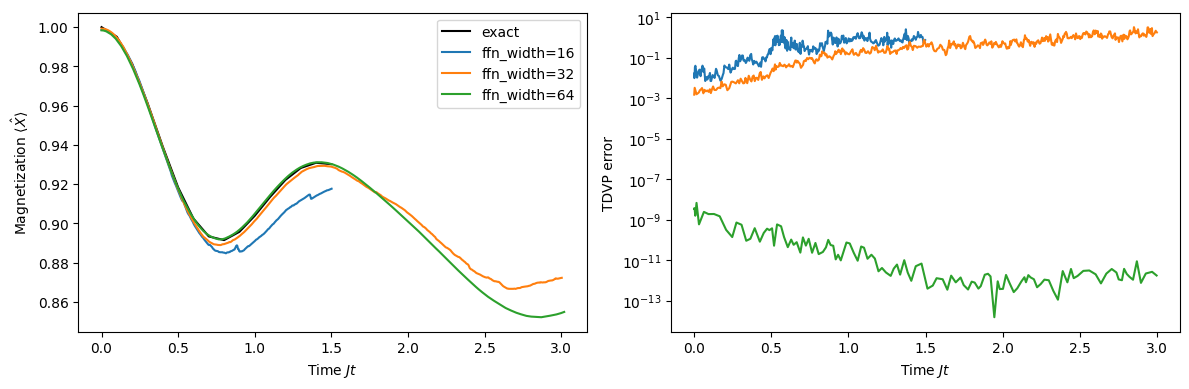

In [43]:
plot_observables(L, g, h, fns=["ffn_width="+str(16)+"_", "ffn_width="+str(32)+"_", "ffn_width="+str(64)+"_"])